# Chess Blunder Detection — Main Pipeline

End-to-end notebook: **data → features → training → evaluation → prediction**

Run cells in order. Everything is orchestrated through `src/`.

## 0 · Environment Setup

In [23]:
pip install xgboost chess numpy scikit-learn matplotlib joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# # Install dependencies (only needed once per environment)
# import subprocess, sys
# subprocess.check_call([
#     sys.executable, '-m', 'pip', 'install', '--quiet',
#     'xgboost', 'scikit-learn', 'pandas', 'numpy', 'chess', 'joblib'
# ])
# print('Dependencies ready.')

In [25]:
import sys, os

# Make sure the workspace root is on the Python path so `src` is importable
ROOT = os.path.abspath('')
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from src.preprocessing import build_dataset, FEATURE_COLUMNS
from src.train         import train, evaluate, save_model, load_model
from src.predict       import predict_game, predict_position

print('Imports OK')

Imports OK


---
## 1 · Load & Inspect Raw Data

In [26]:
import pandas as pd

raw = pd.read_csv('data/raw/positions.csv')
print(f'Raw shape: {raw.shape}')
raw.head(3)

C:\Users\User\AppData\Local\Temp\ipykernel_16500\2489232168.py:3: DtypeWarning: Columns (0,1,5,6,7,8,9,10,11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv('data/raw/positions.csv')


Raw shape: (1048575, 17)


,fen,playing,score,mate,depth,game_id,date,time,white,black,white_result,black_result,white_elo,black_elo,opening,time_control,termination
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,e2e4,-35.0,NaN,20.0,j1dkb5dw,2012.12.31,23:01:03,BFG9k,mamalak,1,0,1639.0,1403,French Defense: Normal Variation,600+8,Normal
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,e7e6,36.0,NaN,22.0,j1dkb5dw,2012.12.31,23:01:03,BFG9k,mamalak,1,0,1639.0,1403,French Defense: Normal Variation,600+8,Normal
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,d2d4,-27.0,NaN,24.0,j1dkb5dw,2012.12.31,23:01:03,BFG9k,mamalak,1,0,1639.0,1403,French Defense: Normal Variation,600+8,Normal


In [27]:
raw.dtypes

fen              object
playing          object
score           float64
mate            float64
depth           float64
game_id          object
date             object
time             object
white            object
black            object
white_result     object
black_result     object
white_elo       float64
black_elo        object
opening          object
time_control     object
termination      object
dtype: object

In [28]:
raw.isnull().sum()[raw.isnull().sum() > 0]

fen              948652
playing          948652
score            958610
mate            1038617
depth            948652
game_id          948652
date             948652
time             948652
white            948652
black            948652
white_result     948652
black_result     948652
white_elo        948652
black_elo        948652
opening          948652
time_control     948652
termination      948652
dtype: int64

In [29]:
raw.head(3)

,fen,playing,score,mate,depth,game_id,date,time,white,black,white_result,black_result,white_elo,black_elo,opening,time_control,termination
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,e2e4,-35.0,NaN,20.0,j1dkb5dw,2012.12.31,23:01:03,BFG9k,mamalak,1,0,1639.0,1403,French Defense: Normal Variation,600+8,Normal
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,e7e6,36.0,NaN,22.0,j1dkb5dw,2012.12.31,23:01:03,BFG9k,mamalak,1,0,1639.0,1403,French Defense: Normal Variation,600+8,Normal
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,d2d4,-27.0,NaN,24.0,j1dkb5dw,2012.12.31,23:01:03,BFG9k,mamalak,1,0,1639.0,1403,French Defense: Normal Variation,600+8,Normal


---
## 2 · Build Dataset (full pipeline)

In [30]:
X, y = build_dataset('data/raw/positions.csv')
X.head()

e:\ML\Blunder_chess\src\preprocessing.py:69: DtypeWarning: Columns (0,1,5,6,7,8,9,10,11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Original shape: (1048575, 17)
After cleaning: (89918, 17)
After blunder labelling: (88356, 19)  |  blunder rate: 55.7%
FEN features added: material_diff, total_pieces, in_check
Player features added: rating_diff, avg_rating, base_time

Final dataset: 88,356 samples, 9 features
Blunders: 49,223  (55.7%)


,white_elo,black_elo,depth,material_diff,total_pieces,in_check,rating_diff,avg_rating,base_time
0,1500.0,1478.0,23.0,-200,20,0,22.0,1489.0,300.0
1,1500.0,1478.0,24.0,-200,20,0,22.0,1489.0,300.0
2,1500.0,1478.0,24.0,-700,21,0,22.0,1489.0,300.0
3,1500.0,1478.0,23.0,-200,22,0,22.0,1489.0,300.0
4,1500.0,1478.0,23.0,100,23,0,22.0,1489.0,300.0


In [31]:
print('Label distribution:')
print(y.value_counts())
print()
print(f'Blunder rate: {y.mean()*100:.1f}%')

Label distribution:
blunder
1    49223
0    39133
Name: count, dtype: int64

Blunder rate: 55.7%


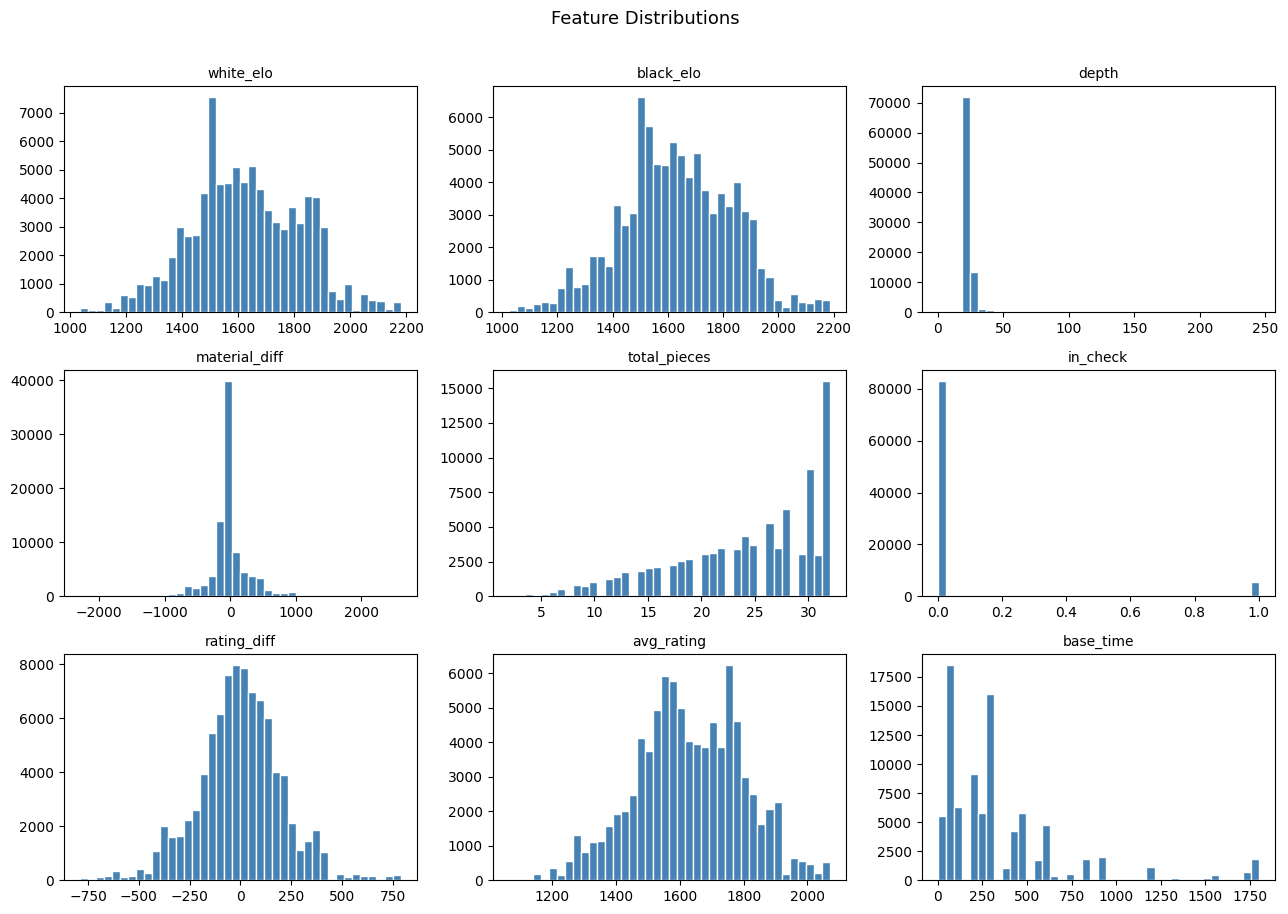

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(13, 9))
axes = axes.flatten()

for i, col in enumerate(FEATURE_COLUMNS):
    axes[i].hist(X[col].dropna(), bins=40, edgecolor='white', color='steelblue')
    axes[i].set_title(col, fontsize=10)

plt.suptitle('Feature Distributions', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## 3 · Train the Model

In [33]:
model, X_test, y_test = train(X, y)

scale_pos_weight = 0.80  (neg=31,306 / pos=39,378)
Training XGBoost …


c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:200: UserWarning: [11:54:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.


---
## 4 · Evaluate

In [34]:
evaluate(model, X_test, y_test)


XGBOOST RESULTS
Accuracy: 77.33 %

              precision    recall  f1-score   support

      Normal       0.74      0.76      0.75      7827
     Blunder       0.81      0.78      0.79      9845

    accuracy                           0.77     17672
   macro avg       0.77      0.77      0.77     17672
weighted avg       0.77      0.77      0.77     17672



In [35]:
print(X_test)

       white_elo  black_elo  depth  material_diff  total_pieces  in_check  \
31445     1802.0     1734.0   25.0           -100            25         0   
53557     1756.0     1548.0   20.0              0            32         0   
27050     1893.0     1513.0   26.0           -100            25         0   
52889     1635.0     1698.0   22.0              0            28         0   
87821     1792.0     1728.0   22.0           -200            18         0   
...          ...        ...    ...            ...           ...       ...   
66267     1635.0     1594.0   24.0              0            32         0   
44479     1440.0     1502.0   24.0              0            32         0   
74960     1906.0     1675.0   24.0              0            28         0   
8409      1656.0     1695.0   19.0            100            23         0   
57183     1436.0     1867.0   24.0           -100            31         0   

       rating_diff  avg_rating  base_time  
31445         68.0      1768.0 

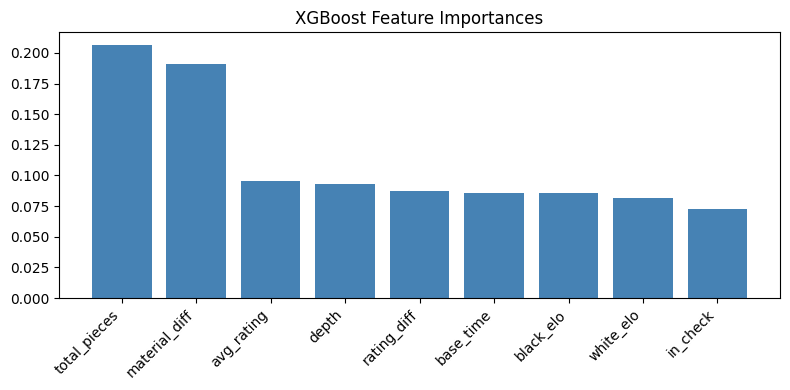

In [36]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices     = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.bar(range(len(FEATURE_COLUMNS)), importances[indices], color='steelblue')
plt.xticks(range(len(FEATURE_COLUMNS)),
           [FEATURE_COLUMNS[i] for i in indices], rotation=45, ha='right')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

---
## 5 · Save Model

In [37]:
save_model(model)

Model saved → models\blunder_model.pkl


---
## 6 · Predict on Sample PGN Game (Option 1)

In [38]:
results = predict_game('data/raw/sample_game.pgn')
print(results.to_string(index=False))

 Move_Number Move_SAN  Side  Blunder_Probability
           1       d4 White               0.1308
           1       d6 Black               0.1308
           2       c4 White               0.1308
           2       c6 Black               0.1308
           3       e3 White               0.1308
           3       e6 Black               0.1308
           4      Nc3 White               0.1308
           4       h6 Black               0.1308
           5      Nf3 White               0.1308
           5       b6 Black               0.1308
           6      Be2 White               0.1308
           6      Bb7 Black               0.1308
           7      Bd2 White               0.1308
           7      Nd7 Black               0.1308
           8      O-O White               0.1308
           8       a6 Black               0.1308
           9       b3 White               0.1308
           9       c5 Black               0.1308
          10     dxc5 White               0.1308
          10     Nxc

In [39]:
suspected = results[results['Blunder_Probability'] > 0.5]
print(f'Suspected blunders (p > 0.50): {len(suspected)}')
suspected

Suspected blunders (p > 0.50): 28


,Move_Number,Move_SAN,Side,Blunder_Probability
32,17,Rxc3,White,0.7865
33,17,Be7,Black,0.5800
34,18,Rc1,White,0.5800
35,18,O-O,Black,0.5800
36,19,Re1,White,0.5800
37,19,Rc8,Black,0.5800
38,20,c5,White,0.5800
39,20,bxc5,Black,0.5800
40,21,bxc5,White,0.8960
41,21,Rxc5,Black,0.7996


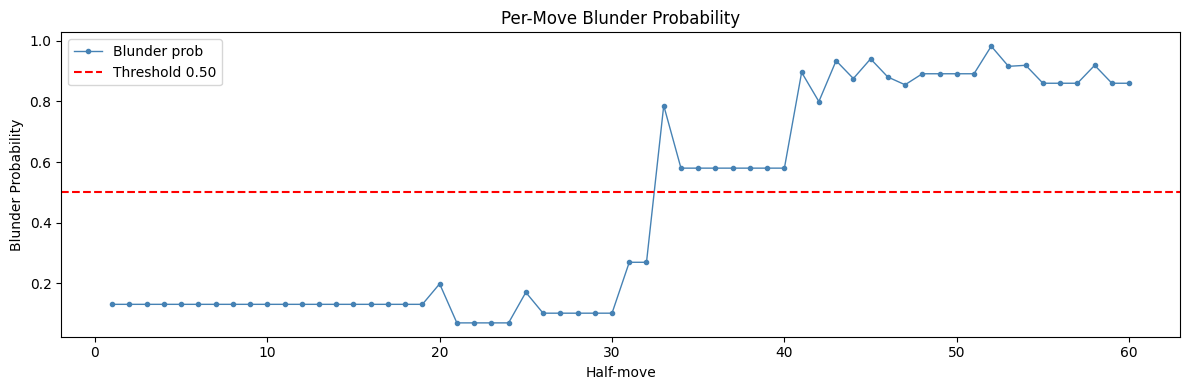

In [40]:
plt.figure(figsize=(12, 4))
plt.plot(results.index + 1, results['Blunder_Probability'],
         marker='o', markersize=3, linewidth=1, color='steelblue', label='Blunder prob')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold 0.50')
plt.xlabel('Half-move')
plt.ylabel('Blunder Probability')
plt.title('Per-Move Blunder Probability')
plt.legend()
plt.tight_layout()
plt.show()

---
## 7 · Predict a Single Position (Option 2)

In [ ]:
prob = predict_position({
    'white_elo':     1639,
    'black_elo':     1403,
    'depth':         20,
    'material_diff': 0,
    'total_pieces':  28,
    'in_check':      0,
    'rating_diff':   236,
    'avg_rating':    1521.0,
    'base_time':     600.0,
})

label = 'LIKELY BLUNDER' if prob > 0.5 else ' Probably OK'
print(f'{label}  (probability: {prob:.1%})')

 Probably OK  (probability: 31.2%)


: 